In [ ]:
%%capture
#analysis should complete within 4 minutes 
#using 1 threads 
# julia --threads=4 --project=@. ./extract_theta_native.jl
# ARGS[1] = "nointerannual"
include("../src/intro.jl")
include("../src/OHC_helper.jl")


using Revise,ECCOonPoseidon, ECCOtour,
MeshArrays, MITgcmTools, JLD2, DrWatson, Statistics, JLD2,
NCDatasets, Printf, 
DataFrames, LaTeXStrings,
Plots
import NaNMath as nm
using .OHC_helper
import PyPlot as plt
using PyCall;

In [4]:
@pyimport seaborn as sns;
@pyimport pandas as pd;
colors =  sns.color_palette("deep")[1:4]
sns.set_theme(context = "talk", font_scale = 1.0,
              palette = sns.color_palette("deep"));#sns.set_context("talk")
pygui(true)
cm = pyimport("cmocean.cm");colorway = cm.balance;
include(srcdir("config_exp.jl"));
(ϕ,λ) = latlonC(γ)
area = readarea(γ)
runpath,diagpath = listexperiments(exprootdir());
ignore_list= ["noIA", "129ff"]
shortnames = OHC_helper.reduce_dict(expnames(), ignore_list)
tecco = 1992+1/24:1/12:2018;

Configure the experiment variables and directories
Available experiments are
iter129_bulkformula
convert_ECCO_nc_to_mat.asv
checkout_plots.asv
noinitadjust
nosfcadjust
interannual_southpac
add_sigma1_windstresscurl.m
convert_ECCO_nc_to_mat.m
iter0_bulkformula
checkout_plots.m
iter129_fluxforced
nointerannual
compare_timeseries.m


/home/ameza/.julia/conda/3/lib/python3.9/inspect.py:351: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/ameza/.julia/conda/3/lib/python3.9/inspect.py:351: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)
/home/ameza/.julia/conda/3/lib/python3.9/inspect.py:351: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  value = getattr(object, key)


In [5]:
ocean_mask = OHC_helper.wet_pts(Γ)
region = "NPAC"; 
PAC_msk = OHC_helper.PAC_mask(Γ, basins, basin_list, ϕ, λ; 
                            region, include_bering = false)
msk = PAC_msk;
(msk == ocean_mask) && (region = "GLOB")
suffix = "sfctobot"
uplvl =  Inf; botlvl = -Inf
lvls = findall( botlvl .<= z[:].<= uplvl)

cell_depths = get_cell_depths(msk, ΔzF, Γ.hFacC); cell_volumes = get_cell_volumes(area, cell_depths);
smush_depths = smush(cell_depths); smush_depths[findall(smush_depths .== 0)] = Inf
inv_depths = 1 ./ smush_depths;

In [6]:
function filter_θ(γ::gcmgrid, diagpath::Dict{String, String}, expname::String, 
    θz::Dict, θ_depths::Dict, θ_zonal::Dict, θsurf::Dict, 
    lvls::Vector{Int64}, 
    mask ::MeshArray,
    inv_depths::MeshArrays.gcmarray{T, 1, Matrix{T}},
    cell_volumes::MeshArrays.gcmarray{T, 2, Matrix{T}}) where T <: Real

    vol_weight(x::MeshArray) = Float32(sum(x .* mask) / tot_vol)

    filelist = searchdir(diagpath[expname],"state_2d_set1") # first filter for state_3d_set1
    datafilelist_S  = filter(x -> occursin("data",x),filelist) # second filter for "data"
    filelist = searchdir(diagpath[expname],"state_3d_set1") # first filter for state_3d_set1
    datafilelist_θ  = filter(x -> occursin("data",x),filelist) # second filter for "data"

    nt = length(datafilelist_θ)
    nlev = length(lvls)

    θsurf[expname] = zeros(Float32, nt)
    θz[expname] = zeros(Float32, nt)
    θ_depths[expname] = zeros(Float32, nlev, nt)
    θ_zonal[expname] = zeros(nlev, 270, nt)

    Threads.@threads for tt = 1:nt
        fnameS = datafilelist_S[tt]
        fnameθ = datafilelist_θ[tt]
        sθ = extract_sθ(expname,diagpath, γ, fnameS, fnameθ, inv_depths)
        sθ_mask = sθ[:, lvls] .* mask #apply mask and crop 

        θsurf[expname][tt] = Float32.(volume_mean(sθ[:, 1] .* mask; weights = cell_volumes[:, 1]))
        θz[expname][tt] = Float32.(volume_mean(sθ_mask; weights = cell_volumes[:, lvls]))
        θ_depths[expname][:, tt] .= ma_horiz_avg(sθ_mask, cell_volumes[:, lvls])
        θ_zonal[expname][:, :, tt] .= ma_zonal_avg(sθ_mask, cell_volumes[:, lvls])
        GC.safepoint()
    end
end



filter_θ (generic function with 1 method)

In [7]:
θz, θ_depths, θ_zonal = Dict(), Dict(), Dict()
θsurf = Dict()
@time for expname in keys(shortnames)
    println(expname)
    filter_θ(γ, diagpath, expname, 
             θz, θ_depths, θ_zonal, θsurf, 
             lvls, msk, inv_depths, cell_volumes)
end

In [ ]:
@time include("plot_divergence_theta_zonal_mean.jl") 

In [87]:
df = DataFrame(θz);
# df = df .- mean.(eachcol(df))';
df_mean = mean(eachcol(df))
df = df .- df_mean;
θz_prime = Dict(key => df[!, key] for key in keys(θz))



Dict{String, Vector{Float32}} with 4 entries:
  "iter129_bulkformula" => [0.00112188, 0.0011729, 0.00119913, 0.00119889, 0.00…
  "noinitadjust"        => [-0.00111949, -0.00116694, -0.00121558, -0.0012641, …
  "nosfcadjust"         => [0.00111914, 0.00116384, 0.00120795, 0.00125408, 0.0…
  "iter0_bulkformula"   => [-0.00112128, -0.00117004, -0.00119114, -0.00118899,…

In [88]:
labels_L = [L"\theta^{\Delta T , \Delta F}", L"\theta^{0, \Delta F}",L"\theta^{\Delta T, 0}", L"\theta^{0, 0}"]

labels_L = Dict(key => labels_L[i] for (i, key) in enumerate(keys(θz)))
colors_dict = Dict(key => colors[i] for (i, key) in enumerate(keys(θz)));



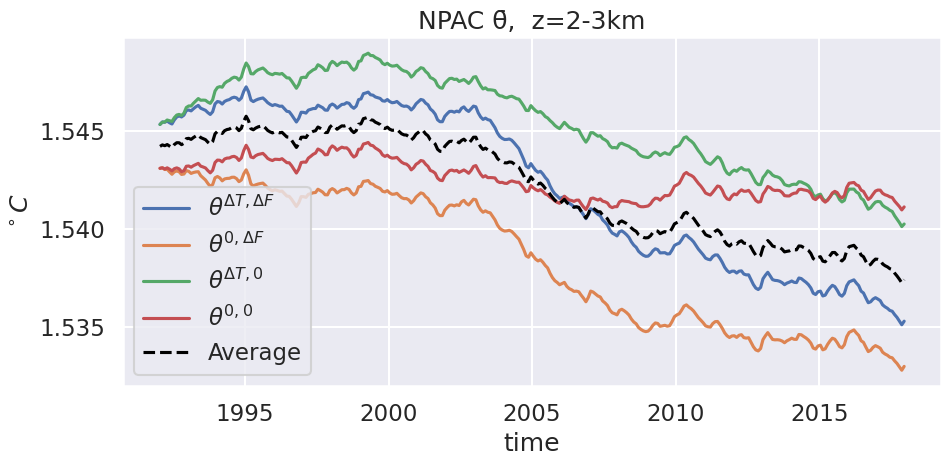

In [92]:
pygui(false)
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.set_title(region *  " θ̄,  z=2-3km")
θz_mean = mean(eachcol(DataFrame(θz)))
[ax.plot(tecco, value, c = colors_dict[key], label = labels_L[key]) for (key, value) in θz]
ax.plot(tecco, θz_mean, c = "k", linestyle = "--", label = "Average")
ax.legend(); ax.set_ylabel(L"^\circ C"); ax.set_xlabel("time")
fig.tight_layout()


4-element Vector{Float32}:
 1.5431007
 1.5453439
 1.5431025
 1.5453411

In [140]:
pygui(false)
df = DataFrame(θz)
df .-= Array(df[1, :])';
θz_noninit = Dict(key => df[!, key] for key in keys(θz))

Dict{String, Vector{Float32}} with 4 entries:
  "iter129_bulkformula" => [0.0, 0.000125408, 0.000111341, 0.000169635, 8.38041…
  "noinitadjust"        => [0.0, 2.69413f-5, -6.19888f-5, -5.19753f-5, -0.00018…
  "nosfcadjust"         => [0.0, 0.00011909, 0.000122905, 0.000227571, 0.000189…
  "iter0_bulkformula"   => [0.0, 2.563f-5, -3.57628f-5, 2.49147f-5, -4.3869f-5,…

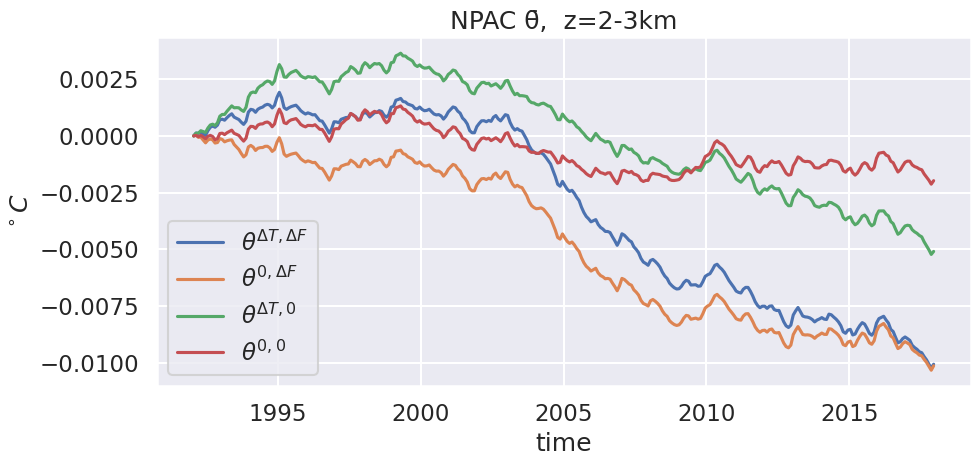

In [141]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.set_title(region *  " θ̄,  z=2-3km")
# θz_mean = mean(eachcol(DataFrame(θz)))
[ax.plot(tecco, value, c = colors_dict[key], label = labels_L[key]) for (key, value) in θz_noninit]
# ax.plot(tecco, θz_mean, c = "k", linestyle = "--", label = "Average")
ax.legend(); ax.set_ylabel(L"^\circ C"); ax.set_xlabel("time")
fig.tight_layout()



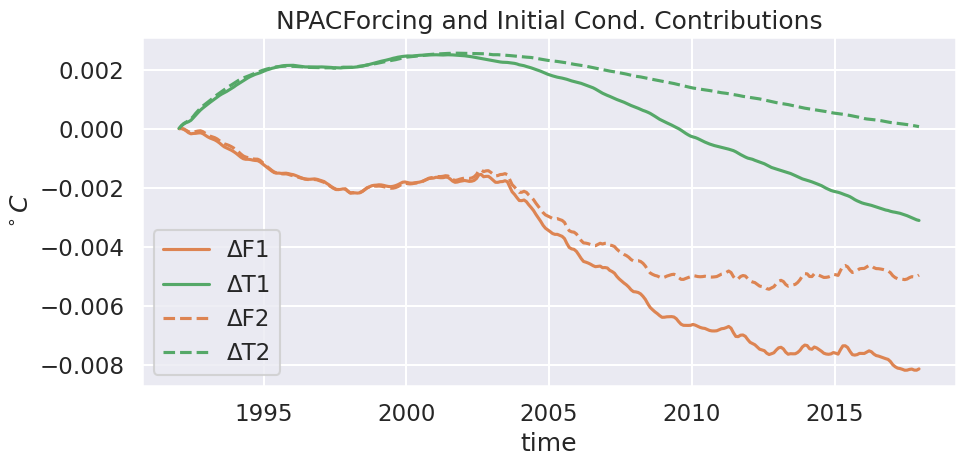

In [142]:
θΔF = df.noinitadjust
θΔT = df.nosfcadjust
θΔTF = df.iter129_bulkformula
θΔ0 = df.iter0_bulkformula

ΔF1 = θΔF .- θΔ0
ΔF2 = θΔTF .- θΔT
ΔT1 = θΔT .- θΔ0
ΔT2 = θΔTF .- θΔF;

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.set_title(region *  "Forcing and Initial Cond. Contributions")
ax.plot(tecco, ΔF1, label = "ΔF1", c = colors[2]); 
ax.plot(tecco, ΔT1, label = "ΔT1", c = colors[3]); 
ax.plot(tecco, ΔF2, label = "ΔF2", linestyle = "--", c = colors[2])
ax.plot(tecco, ΔT2, label = "ΔT2", linestyle = "--", c = colors[3])
ax.legend(); ax.set_ylabel(L"^\circ C"); ax.set_xlabel("time")
fig.tight_layout()




┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/ameza/.julia/packages/Convex/ukggP/src/solution.jl:342


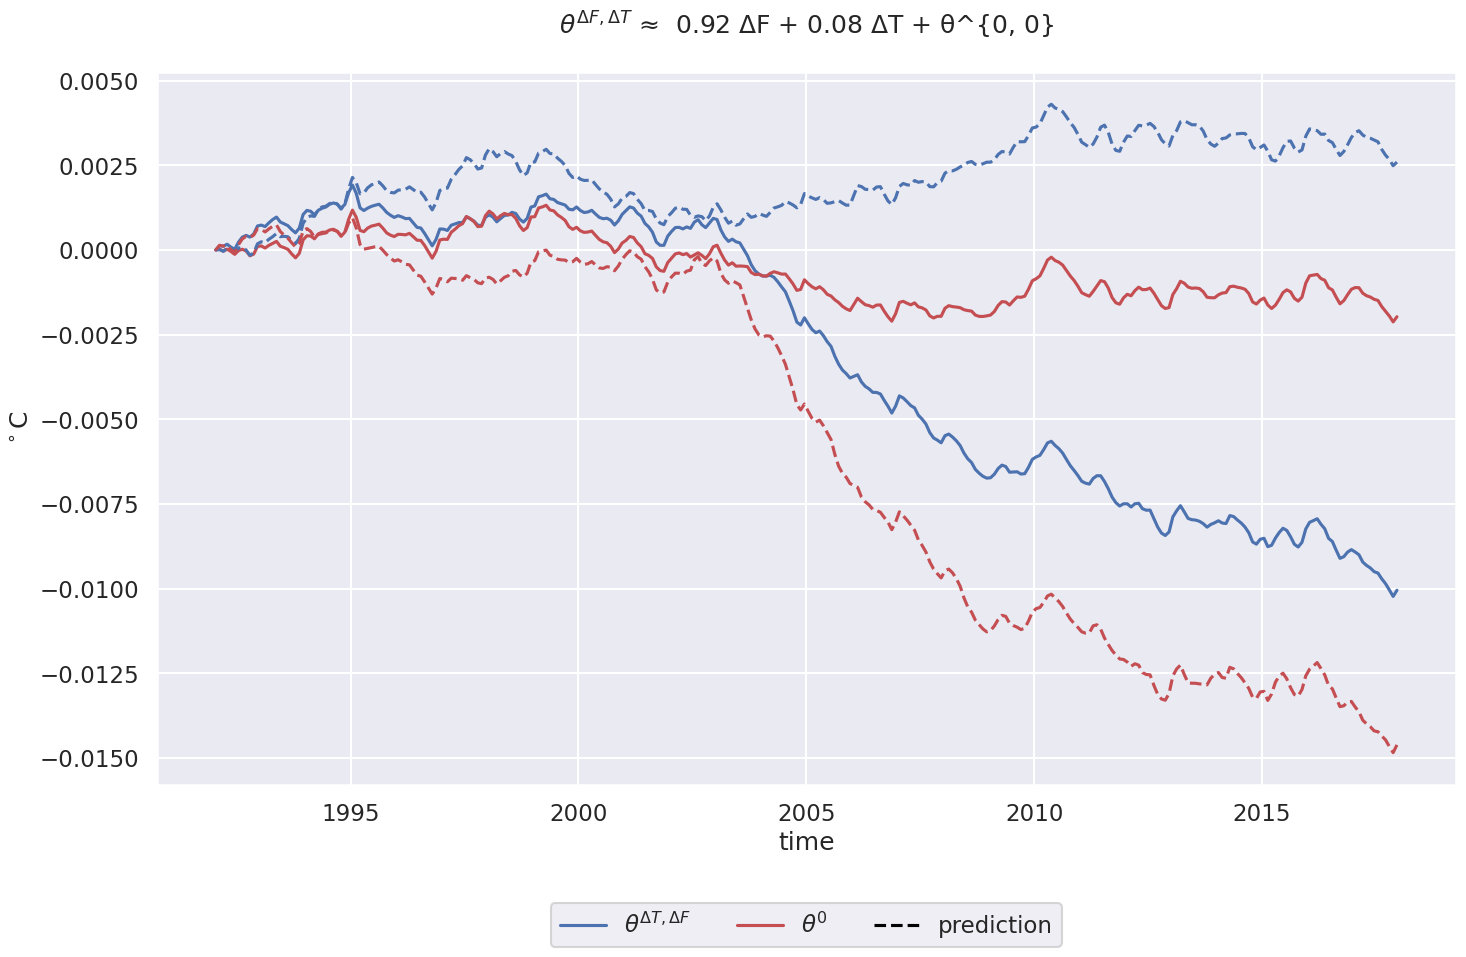

In [155]:
using Convex, SCS
const MOI = Convex.MOI

A = [ΔF2 ΔT2]
A_iter129 = deepcopy(A) 

b =  df.iter129_bulkformula .- df.iter0_bulkformula;
params = Variable(2,  Positive())
add_constraint!(params, sum(params) == 1)
problem = minimize(sumsquares(A*params -b))
solve!(problem, MOI.OptimizerWithAttributes(SCS.Optimizer,  
"eps_abs" => 1e-13, "eps_rel" => 1e-13), silent_solver = true)
coefs = round.(params.value, digits = 3)

iter0_predict = df.iter129_bulkformula .- (A_iter129 * coefs) 
iter129_predict = df.iter0_bulkformula .+  (A_iter129 * coefs);

fig, ax = plt.subplots(1, figsize = (15, 10))
ax.plot(tecco, df.iter129_bulkformula, c = colors[1], label = L"\theta^{\Delta T, \Delta F}")
ax.plot(tecco, df.iter0_bulkformula,  c = colors[4], label = L"\theta^{0}")
ax.plot(tecco, iter129_predict, c = colors[1], linestyle = "--")
ax.plot(tecco, iter0_predict, c = colors[4], linestyle = "--")
ax.plot(tecco, NaN.*tecco, c = "k", linestyle = "--", label = "prediction")

c1, c2 = round.(coefs, digits = 2)
# c1 = 0.68; c2 = 0.85
ax.set_title(L"θ^{ΔF, ΔT}" * " ≈  $c1 ΔF + $c2 ΔT " * L"+ θ^{0, 0}" * "\n")


ax.set_xlabel("time");ax.set_ylabel(L"^\circ"*"C")
ax.legend();sns.move_legend(ax, "upper center", bbox_to_anchor=(.5, -.15), ncol=5)
path = "/OHC_Divergence/Reconstructions/" * "θPredCVX_about129_" * region * "_" * suffix * ".png"
fig.tight_layout(); fig.savefig(plotsdir() * path, dpi = 1000)

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/ameza/.julia/packages/Convex/ukggP/src/solution.jl:342


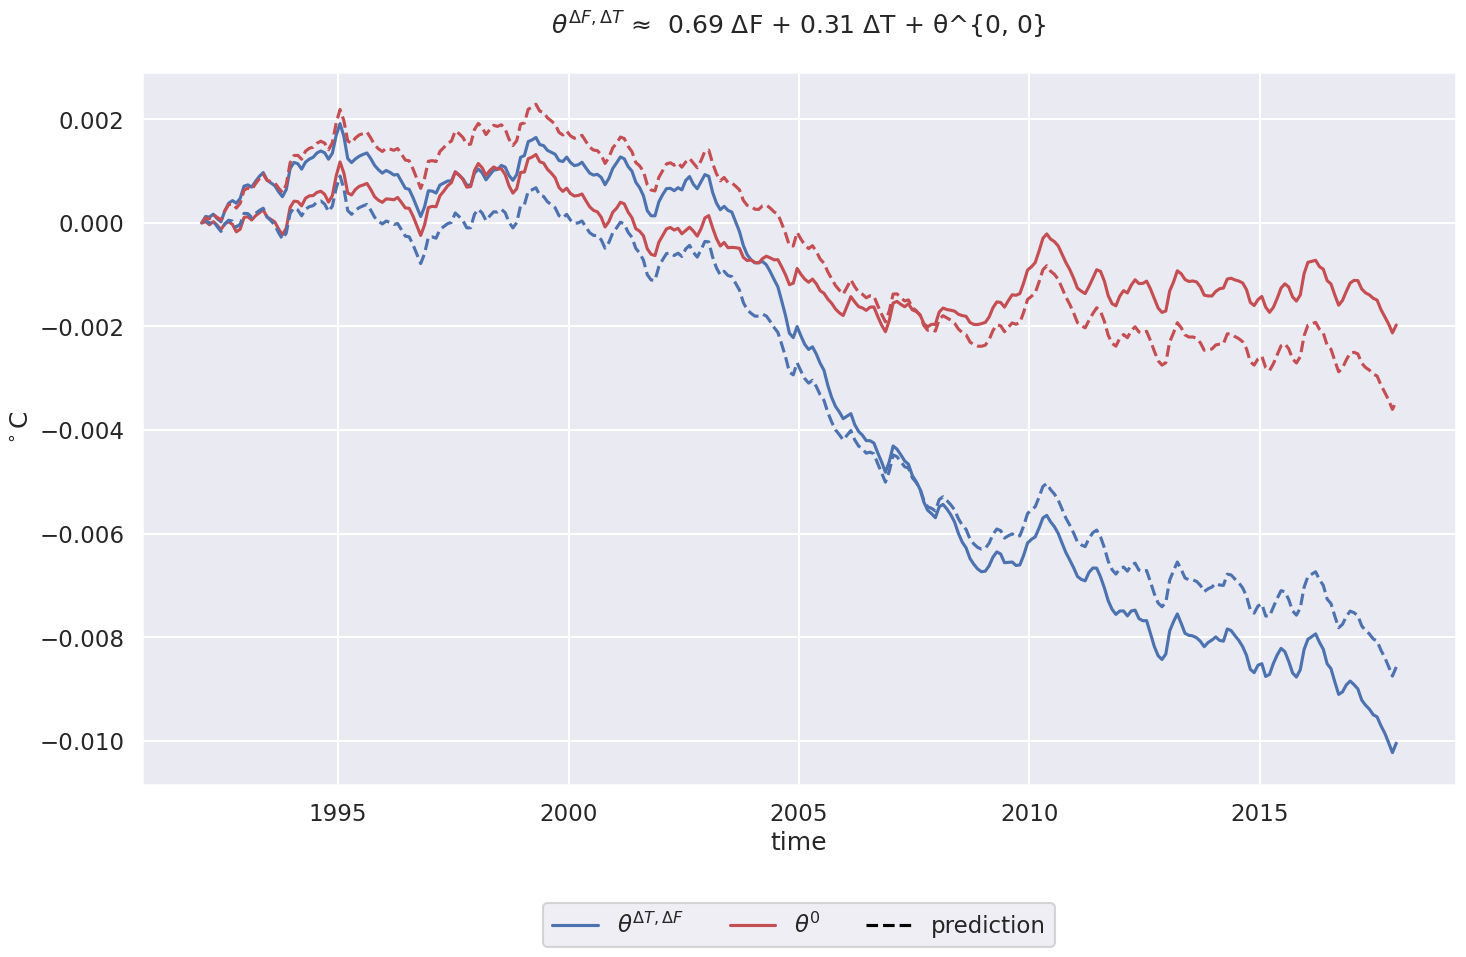

In [154]:
A = [ΔF1 ΔT1]
A_iter0 = deepcopy(A) 

b =  df.iter129_bulkformula .- df.iter0_bulkformula;
params = Variable(2,  Positive())
add_constraint!(params, sum(params) == 1)
problem = minimize(sumsquares(A*params -b))
solve!(problem, MOI.OptimizerWithAttributes(SCS.Optimizer,  
"eps_abs" => 1e-13, "eps_rel" => 1e-13), silent_solver = true)
coefs = round.(params.value, digits = 3)

iter0_predict = df.iter129_bulkformula .- (A_iter0 * coefs) 
iter129_predict = df.iter0_bulkformula .+  (A_iter0 * coefs);

fig, ax = plt.subplots(1, figsize = (15, 10))
ax.plot(tecco, df.iter129_bulkformula, c = colors[1], label = L"\theta^{\Delta T, \Delta F}")
ax.plot(tecco, df.iter0_bulkformula,  c = colors[4], label = L"\theta^{0}")
ax.plot(tecco, iter129_predict, c = colors[1], linestyle = "--")
ax.plot(tecco, iter0_predict, c = colors[4], linestyle = "--")
ax.plot(tecco, NaN.*tecco, c = "k", linestyle = "--", label = "prediction")

c1, c2 = round.(coefs, digits = 2)
# c1 = 0.68; c2 = 0.85
ax.set_title(L"θ^{ΔF, ΔT}" * " ≈  $c1 ΔF + $c2 ΔT + θ^{0, 0}" * "\n")

ax.set_xlabel("time");ax.set_ylabel(L"^\circ"*"C")
ax.legend();sns.move_legend(ax, "upper center", bbox_to_anchor=(.5, -.15), ncol=5)
path = "/OHC_Divergence/Reconstructions/" * "θPredCVX_about129_" * region * "_" * suffix * ".png"
fig.tight_layout(); fig.savefig(plotsdir() * path, dpi = 1000)